In [118]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import pyspark as ps

In [119]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('constructionPermitsAustin')
         .getOrCreate()
        )
sc = spark.sparkContext

In [120]:
sc

<SparkContext master=local[4] appName=constructionPermitsAustin>

In [121]:
permits_all = spark.read.csv('../data/Issued_Construction_Permits.csv',
                    header=True,
                    sep=",",
                    inferSchema=True)

# permits_all.printSchema()

# print(f'line count: {permits_all.count()}')

# permits_all.show()

In [122]:
permits_all.createOrReplaceTempView('permits')

In [123]:
permits_2019 = spark.sql('SELECT * from permits WHERE `Calendar Year Issued` = 2019')

In [124]:
permits_2020 = spark.sql('SELECT * from permits WHERE `Calendar Year Issued` = 2020')

In [125]:
permits_2020_df = permits_2020.toPandas()

In [126]:
# permits_2020_df.info()

In [127]:
# permits_2020_df['Location'].value_counts()

In [128]:
permits_2020_df_cleaned = permits_2020_df.drop(columns=['Project Name',
                                                        'TCAD ID',
                                                        'Property Legal Description',
                                                        'Issued In Last 30 Days',
                                                        'Issuance Method',
                                                        'Original Address 1',
                                                        'Original City',
                                                        'Original State',
                                                        'Jurisdiction',
                                                        'Link',
                                                        'Project ID',
                                                        'Master Permit Num',
                                                        'Location',
                                                        'Contractor Phone',
                                                        'Contractor Phone',
                                                        'Contractor Phone',
                                                        'Contractor Address 1',
                                                        'Contractor Address 2',
                                                        'Contractor City',
                                                        'Contractor Zip',
                                                        'Applicant Phone',
                                                        'Applicant Address 1',
                                                        'Applicant Address 2',
                                                        'Applicant City',
                                                        'Applicant Zip',
                                                        'Total Lot SQFT'])

# permits_2020_pd_cleaned

In [129]:
permits_2020_df_cleaned['Applied Date'] = pd.to_datetime(permits_2020_df_cleaned['Applied Date'])
permits_2020_df_cleaned['Issued Date'] = pd.to_datetime(permits_2020_df_cleaned['Issued Date'])
permits_2020_df_cleaned['Status Date'] = pd.to_datetime(permits_2020_df_cleaned['Status Date'])
permits_2020_df_cleaned['Expires Date'] = pd.to_datetime(permits_2020_df_cleaned['Expires Date'])
permits_2020_df_cleaned['Completed Date'] = pd.to_datetime(permits_2020_df_cleaned['Completed Date'])

In [130]:
permits_2020_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69317 entries, 0 to 69316
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Permit Type                   69317 non-null  object        
 1   Permit Type Desc              69317 non-null  object        
 2   Permit Num                    69317 non-null  object        
 3   Permit Class Mapped           69317 non-null  object        
 4   Permit Class                  69317 non-null  object        
 5   Work Class                    69317 non-null  object        
 6   Condominium                   53516 non-null  object        
 7   Description                   69317 non-null  object        
 8   Applied Date                  69314 non-null  datetime64[ns]
 9   Issued Date                   69317 non-null  datetime64[ns]
 10  Day Issued                    69317 non-null  object        
 11  Calendar Year Issued        

In [131]:
permit_year = spark.sql('''SELECT `Calendar Year Issued`, COUNT(*)
                        from permits 
                        WHERE `Calendar Year Issued` > 1990 AND `Calendar Year Issued` < 2021
                        GROUP BY `Calendar Year Issued`
                        ORDER BY 1''')

<AxesSubplot:>

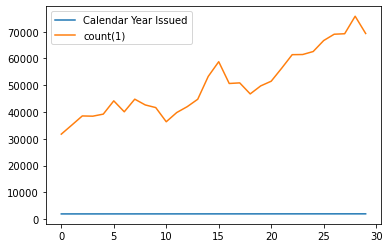

In [132]:
permit_year_df = permit_year.toPandas()
permit_year_df.plot()

In [149]:
permit_date = spark.sql('''SELECT `Applied Date`,`Issued Date`
                        from permits 
                        ORDER BY 2''')

In [150]:
permit_date_df = permit_date.toPandas().dropna()

In [151]:
permit_date_df['Applied Date'] = pd.to_datetime(permit_date_df['Applied Date'])
permit_date_df['Issued Date'] = pd.to_datetime(permit_date_df['Issued Date'])
permit_date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038829 entries, 0 to 2038852
Data columns (total 2 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Applied Date  datetime64[ns]
 1   Issued Date   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 46.7 MB


In [311]:
import datetime
permit_date_df_after_1990 = permit_date_df[permit_date_df['Applied Date'] >= datetime.datetime(1990,1,1)]
permit_date_df_after_1990

,Applied Date,Issued Date
477291,1990-01-02,1990-01-02
477292,1990-01-02,1990-01-02
477293,1990-01-02,1990-01-02
477294,1990-01-02,1990-01-02
477295,1990-01-02,1990-01-02
...,...,...
2038848,2020-05-15,2021-03-28
2038849,2019-12-10,2021-03-28
2038850,2021-01-19,2021-03-28
2038851,2021-02-03,2021-03-28


In [377]:
permit_by_month = permit_date_df_after_1990.groupby(permit_date_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_by_month.index = permit_by_month.index.astype('datetime64[ns]')
permit_by_month['# of Applications'] = permit_by_month['Applied Date']
permit_by_month = permit_by_month.drop(['Applied Date'], axis=1)
permit_by_month = permit_by_month.drop(['Issued Date'], axis=1)
permit_by_month

,# of Applications
Applied Date,
1990-01-01,2525
1990-02-01,2449
1990-03-01,2844
1990-04-01,2580
1990-05-01,3030
...,...
2020-11-01,4037
2020-12-01,3445
2021-01-01,3205


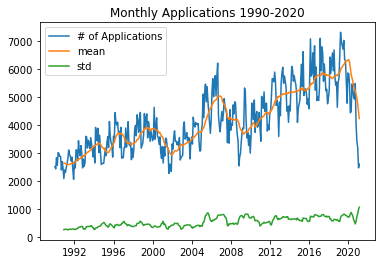

In [406]:
fig, ax = plt.subplots()
ax.plot(permit_by_month, label="# of Applications")
ax.plot(permit_by_month.rolling(window=12).mean(), label="mean")
ax.plot(permit_by_month.rolling(window=12).std(), label="std")
ax.legend()
ax.set_title("Monthly Applications 1990-2020");

In [379]:
pending_time = (permit_date_df_after_1990['Issued Date'] - permit_date_df_after_1990['Applied Date'])

In [380]:
pending_time = pending_time.dt.days.astype('int16')

In [381]:
pending_time_slice = pending_time[(pending_time <= 50) & (pending_time > 0)]

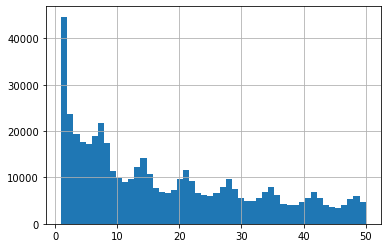

In [382]:
pending_time_slice.hist(bins=50);

In [407]:
permit_by_month_2010_2020 = permit_by_month[
    (permit_by_month.index  >= datetime.datetime(2010,1,1)) &
    (permit_by_month.index  < datetime.datetime(2020,1,1))]
permit_by_month_2010_2020

,# of Applications
Applied Date,
2010-01-01,3010
2010-02-01,3642
2010-03-01,4797
2010-04-01,4604
2010-05-01,4205
...,...
2019-08-01,7034
2019-09-01,6350
2019-10-01,6313


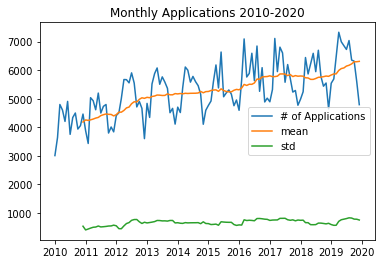

In [409]:
fig, ax = plt.subplots()
ax.plot(permit_by_month_2010_2020, label="# of Applications")
ax.plot(permit_by_month_2010_2020.rolling(window=12).mean(), label="mean")
ax.plot(permit_by_month_2010_2020.rolling(window=12).std(), label="std")
ax.legend()
ax.set_title("Monthly Applications 2010-2020");

TypeError: 'Text' object is not callable

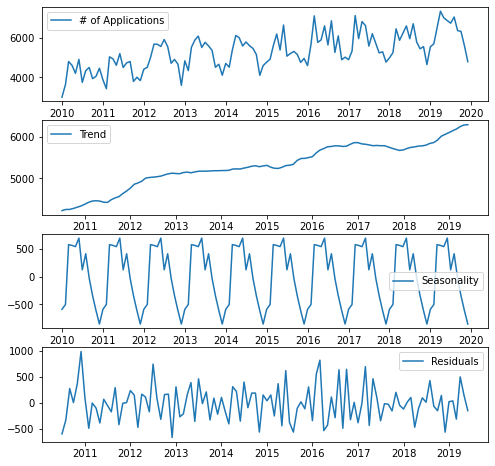

In [412]:
decomposition = seasonal_decompose(permit_by_month_2010_2020, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4, 1, figsize=(8, 8))

ax[0].plot(permit_by_month_2010_2020, label='# of Applications')
ax[0].legend()
ax[1].plot(trend, label='Trend')
ax[1].legend()
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend()
ax[3].plot(residual, label='Residuals')
ax[3].legend()

ax[0].title("Seasonality in Permit Applications")

plt.tight_layout()
seasonal[:12]